In [108]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.decomposition
import numpy as np
import seaborn as sns

import sys
 
# setting path
sys.path.append('/home/p163v/histopathology/software/HEnorm_python')

from normalizeStaining import normalizeStaining 

In [3]:
from scipy.stats import scoreatpercentile

## https://stackoverflow.com/questions/3878245/tukey-five-number-summary-in-python

def fivenumquantile(v):
    """Returns Tukey's five number summary (minimum, lower-hinge, median, upper-hinge, maximum) for the input vector, a list or array of numbers based on 1.5 times the interquartile distance"""
    try:
        np.sum(v)
    except TypeError:
        print('Error: you must provide a list or array of only numbers')
    q1 = scoreatpercentile(v[~np.isnan(v)],25)
    q3 = scoreatpercentile(v[~np.isnan(v)],75)
    md = np.median(v[~np.isnan(v)])
    return np.nanmin(v), q1, md, q3, np.nanmax(v),

In [4]:
tile_name = "63454350-699E-4498-B842-096D9A55E236"

tile_path = '/omics/odcf/analysis/OE0606_projects/pancancer_histopathology/tiles/UKHD_NP_HE_20X_384'

In [5]:
tiles = os.listdir(tile_path+"/" +tile_name)

In [6]:
tiles_chosen = np.random.choice(tiles, 50)

In [7]:
flat_pixels = np.concatenate([np.array(Image.open(tile_path+"/" +tile_name+"/"+f)).reshape([-1,3]) for f in tiles_chosen])

In [8]:
flat_pixels.shape

(7372800, 3)

In [9]:
(flat_pixels/255.0 == 0).sum()

1484

In [10]:
flat_pixels_OD = np.maximum(0.0,-np.log10((flat_pixels+0.01)/255.0))
fivenumquantile(flat_pixels_OD[:,0]),fivenumquantile(flat_pixels_OD[:,1]),fivenumquantile(flat_pixels_OD[:,2])



((0.0,
  0.020916035002472307,
  0.06409775940211837,
  0.14169875510480728,
  1.2301594881906848),
 (0.0,
  0.08223714294712083,
  0.17862777868220703,
  0.3458045769846366,
  4.4065401804339555),
 (0.0,
  0.03916562055975827,
  0.1033225168602864,
  0.213387743581878,
  4.4065401804339555))

In [11]:
flat_pixels_OD_thresholded = flat_pixels_OD[flat_pixels_OD.sum(1) >= 0.15]

In [12]:
pca = sk.decomposition.PCA()
X_log = pca.fit_transform(flat_pixels_OD_thresholded)


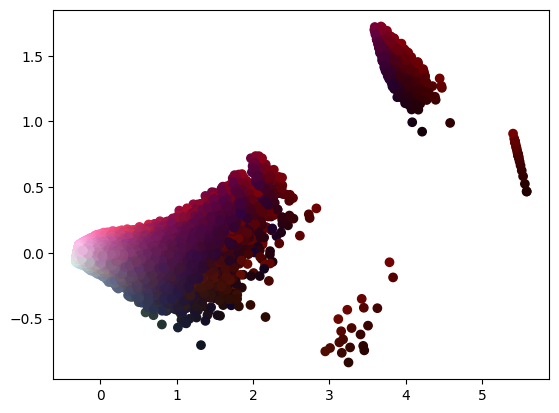

In [13]:
plot_colors = flat_pixels[flat_pixels_OD.sum(1) >= 0.15]/255.0
plt.scatter(X_log[:,0], X_log[:,1], c=plot_colors)
plt.show()

In [ ]:
svd = sk.decomposition.TruncatedSVD()dd

OD_svd = svd.fit_transform(flat_pixels_OD_thresholded)


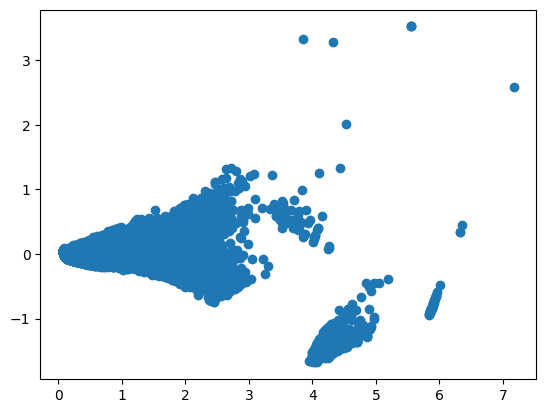

In [ ]:
plt.scatter(OD_svd[:,0], OD_svd[:,1])
plt.show()

In [15]:
_, V = np.linalg.eigh(np.cov(flat_pixels_OD_thresholded, rowvar=False))
V = V[:, [2, 1]]
if V[0, 0] < 0: V[:, 0] *= -1
if V[0, 1] < 0: V[:, 1] *= -1
That = np.dot(flat_pixels_OD_thresholded, V)
phi = np.arctan2(That[:, 1], That[:, 0])
minPhi = np.percentile(phi, 1)
maxPhi = np.percentile(phi, 100 - 1)
v1 = np.dot(V, np.array([np.cos(minPhi), np.sin(minPhi)]))
v2 = np.dot(V, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
if v1[0] > v2[0]:
    HE = np.array([v1, v2])
else:
    HE = np.array([v2, v1])
HE / np.linalg.norm(HE, axis=1)[:, None]


array([[0.52974955, 0.67181915, 0.51771078],
       [0.00454556, 0.93000035, 0.36753052]])

In [16]:
tile = np.array(Image.open(tile_path+"/" +tile_name+"/"+tiles_chosen[0]))

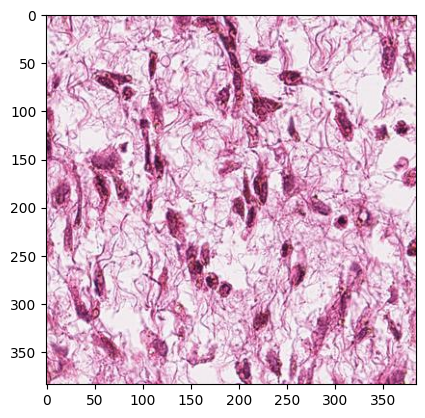

In [17]:
plt.imshow(tile)

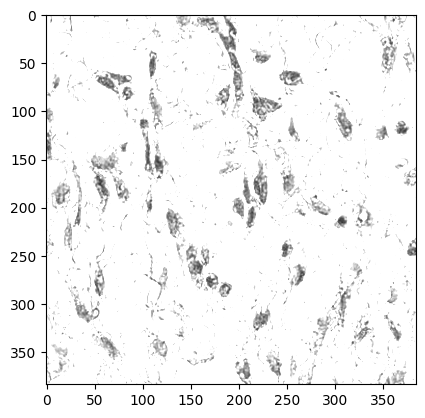

In [18]:
plt.imshow(np.matmul(tile,HE.T)[:,:,0],cmap='gray', vmin=0, vmax=255)

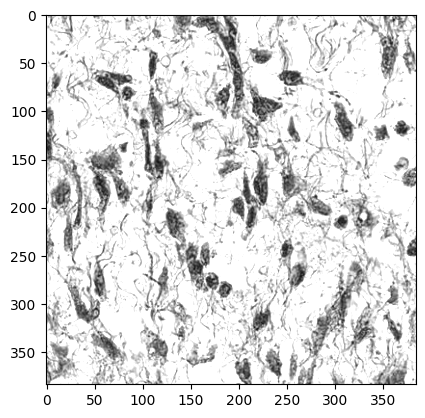

In [19]:
plt.imshow(np.matmul(tile,HE.T)[:,:,1],cmap='gray', vmin=0, vmax=255)

Adapting from : https://github.com/wanghao14/Stain_Normalization/blob/master/stainNorm_Macenko.py

In [231]:
def get_stain_matrix(OD, beta=0.15, alpha=1):
    """
    Get stain matrix (2x3)
    :param I: Image
    :param beta: 
    :param alpha:
    :return:
    """
    # flat_I = I.reshape([-1,3])
    # flat_I = flat_I[~(flat_I==0).any(axis=1),:]
    # OD = -1.0 * np.log(flat_I/255)
    OD = (OD[(OD >= beta).any(axis=1), :])
    _, V = np.linalg.eigh(np.cov(OD, rowvar=False))
    V = V[:, [2, 1]]
    if V[0, 0] < 0: V[:, 0] *= -1
    if V[0, 1] < 0: V[:, 1] *= -1
    That = np.dot(OD, V)
    phi = np.arctan2(That[:, 1], That[:, 0])
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    v1 = np.dot(V, np.array([np.cos(minPhi), np.sin(minPhi)]))
    v2 = np.dot(V, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
    if v1[0] > v2[0]:
        HE = np.array([v1, v2])
    else:
        HE = np.array([v2, v1])
    HE / np.linalg.norm(HE, axis=1)[:, None]
    return HE

def get_concentrations(I):
    """
    Get concentrations, a npix x 2 matrix
    :param I:
    :param stain_matrix: a 2x3 stain matrix
    :return:
    """
    I[I==0] = 1
    OD = -1.0 * np.log(I/255).reshape((-1, 3))
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(get_stain_matrix(OD).T,OD.T, rcond=None)[0]
    return C.transpose([1,0])
    
    
# def deconvolve_tile(I, beta=0.15, alpha=1):
#     I[I==0] = 1
#     stain_mat = get_stain_matrix(OD, beta, alpha)
#     deconv = np.matmul(I,stain_mat.T)
#     return deconv[:,:,0], deconv[:,:,1]

In [232]:
C = get_concentrations(tile)

<Axes: ylabel='Count'>

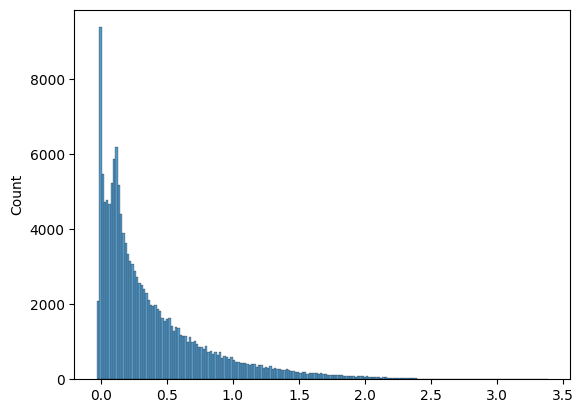

In [234]:
sns.histplot((C[:,0]))

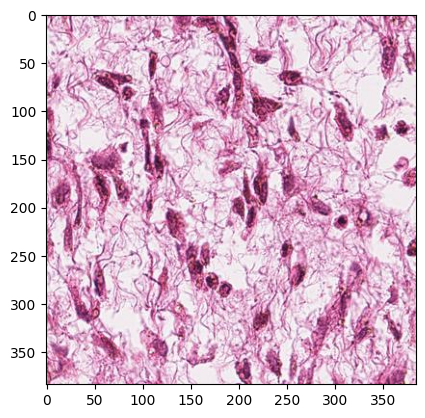

In [222]:
plt.imshow(tile)

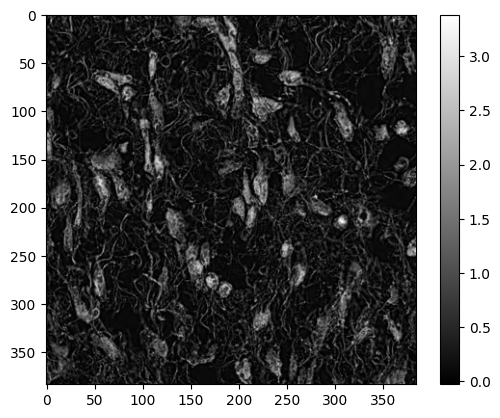

In [235]:
plt.imshow((C[:,0]).reshape([384,384]), cmap="gray")
plt.colorbar()

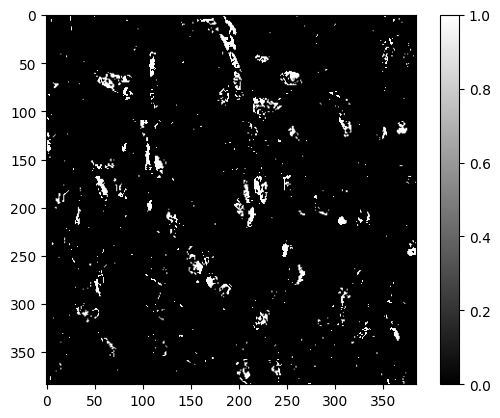

In [221]:
plt.imshow((C[:,0]).reshape([384,384])>1.5, cmap="gray")
plt.colorbar()

<Axes: ylabel='Count'>

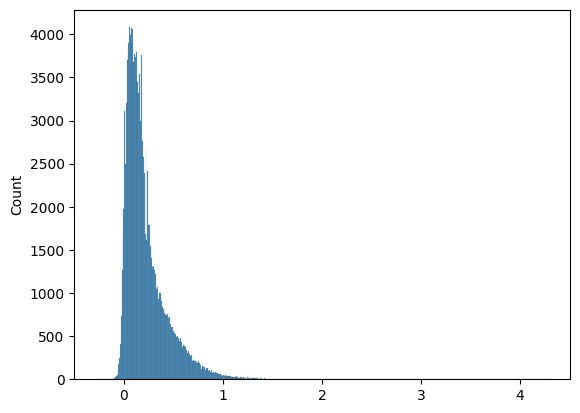

In [236]:
sns.histplot((C[:,1]))

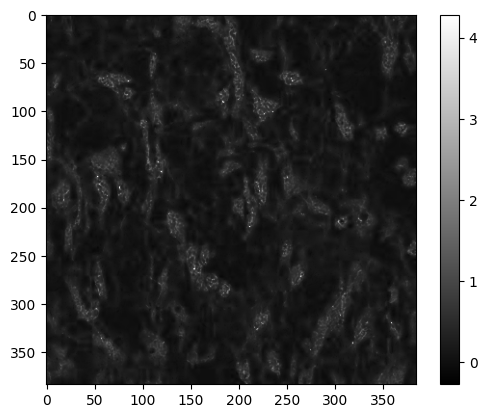

In [237]:
plt.imshow((C[:,1]).reshape([384,384]), cmap="gray")
plt.colorbar()

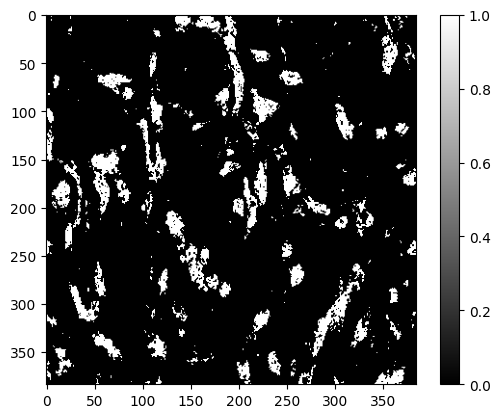

In [238]:
plt.imshow((C[:,1]).reshape([384,384])>0.5, cmap="gray")
plt.colorbar()

In [109]:
norm, H, E = normalizeStaining(tile)

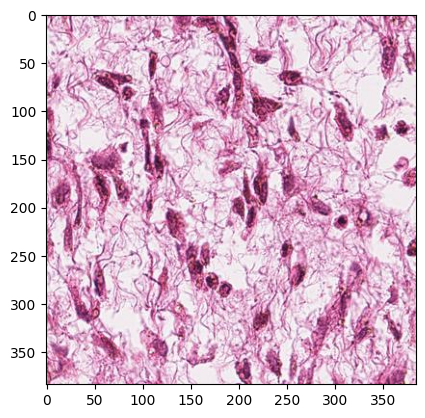

In [110]:
plt.imshow(tile)

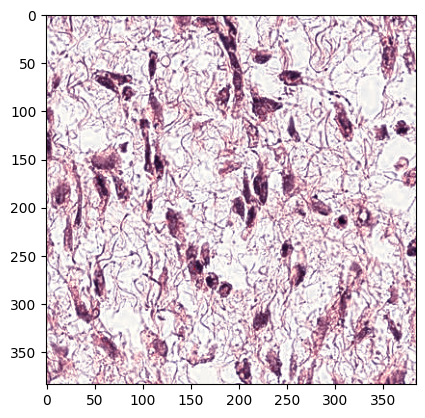

In [111]:
plt.imshow(norm)

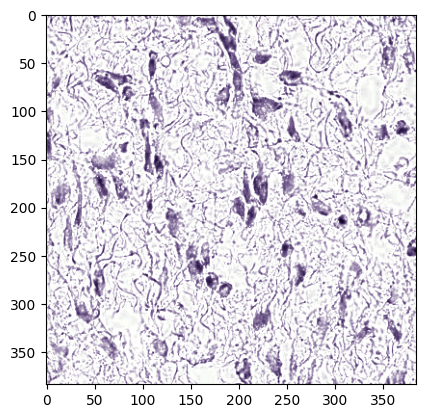

In [114]:
plt.imshow(H)

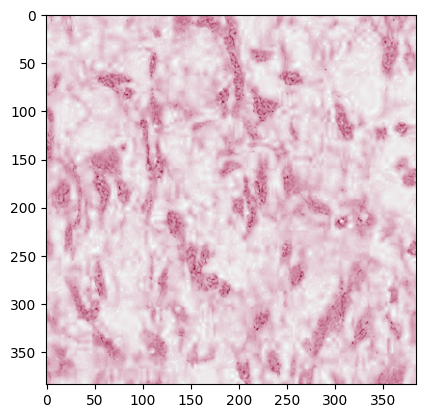

In [115]:
plt.imshow(E)

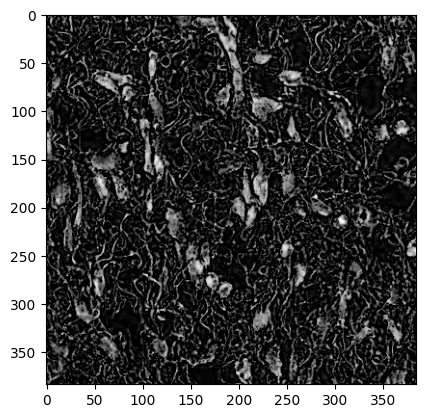

In [224]:
plt.imshow(H.sum(axis=2), cmap="gray_r")

In [ ]:
concs = [get_concentrations(np.array(Image.open(tile_path+"/" +tile_name+"/"+f))) for f in tiles]

In [246]:
ave_H_conc = [x.sum(0)[0]/(384*384) for x in concs]

In [ ]:
sns.histplot(ave_H_conc)